# Classification supervisée des images

## Objectifs

- Classification supervisée des images :
    - réaliser une classification supervisée à partir des images
    - mettre en place une data augmentation afin d’optimiser le modèle
    - fournir une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Préparation des images hors notebook

Les images seront rangées dans deux sous dossiers "train" et "test". A l'intérieur de ces sous dossiers, les images sont rangées par dossier de catégories, soit 7 dossiers catégoriels.

- Images\
    - Train\
        - cat1\
        - ...
    - Test\
        - cat1\
        - ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import os
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/manuel.martin.67/anaconda3/envs/tfm1/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [26]:
# Définition de la variable d'environnement "TF_KERAS" à la valeur '1'
# pour permettre l'utilisation de TensorFlow avec Keras
os.environ["TF_KERAS"]='1'

# Vérification du nombre de GPU disponibles pour l'exécution des calculs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [44]:
# Définition des chemins d'accès aux fichiers
path = "./Flipkart/Images/Train/"
path_test = "./Flipkart/Images/Test/"

# Lecture des données de l'ensemble de données
data_image = pd.read_csv("data_image.csv")

In [46]:
# Définir les noms des sous-dossiers pour Train et Test
train_dir = './Flipkart/Images/Train'
test_dir = './Flipkart/Images/Test'

# Supprimer les dossiers Train et Test s'ils existent déjà
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Recréer les dossiers Train et Test
os.makedirs(train_dir)
os.makedirs(test_dir)

# Calculer le nombre d'images à mettre dans le dossier de test
num_images = len(data_image)
num_test_images = int(0.2 * num_images)

# Sélectionner des images aléatoires pour le dossier de test
test_images = set(random.sample(range(num_images), num_test_images))

# Boucle sur toutes les images et les déplace vers le dossier Train ou Test
for i, row in data_image.iterrows():
    image_name = row['image']
    category = row['categorie_principale']
    image_path = f'./Flipkart/Images/{image_name}'
    if i in test_images:
        # Déplacer l'image vers le dossier de test et créer un sous-dossier pour la catégorie si nécessaire
        category_dir = os.path.join(test_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)
        image_dest = os.path.join(category_dir, image_name)
        shutil.copyfile(image_path, image_dest)
        # Ajouter le chemin de l'image et le statut de test au dataframe
        data_image.loc[i, 'image_path'] = image_dest
        data_image.loc[i, 'Train_Test'] = 'Test'
    else:
        # Déplacer l'image vers le dossier de train et créer un sous-dossier pour la catégorie si nécessaire
        category_dir = os.path.join(train_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)
        image_dest = os.path.join(category_dir, image_name)
        shutil.copyfile(image_path, image_dest)
        # Ajouter le chemin de l'image et le statut de train au dataframe
        data_image.loc[i, 'image_path'] = image_dest
        data_image.loc[i, 'Train_Test'] = 'Train'

# Sélectionner les données d'entraînement (split=train) et de test (split=test)    
data_train = data_image.loc[data_image['Train_Test']=='train'].reset_index(drop=True)
data_test = data_image.loc[data_image['Train_Test']=='test'].reset_index(drop=True)

## Classification supervisée
2 approches :
* sans data augmentation
* avec data augmentation intégrée au modèle


### Classification sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

On crée d'abord une fonction qui va nous créer un modèle VGG16.

Ce modèle sera entrainé uniquement sur les dernières couches fully connected que l'on va rajouter (Flatten, Dense, Dropout et Dense)

On compilera ce modèle avec une fonction de perte, un optimiseur, et une métrique d'évaluation.

In [47]:
def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output

    # Ajouter des couches au modèle
    x = Flatten()(x)  # Mise à plat des résultats
    x = Dense(256, activation='relu')(x)  # Ajoute une couche dense de 256 neurones avec une fonction d'activation ReLU
    x = Dropout(0.5)(x)  # Ajoute une couche de dropout pour éviter le surapprentissage
    predictions = Dense(7, activation='softmax')(x)  # Ajoute une couche dense de 7 neurones avec une fonction d'activation softmax

    # Définir le nouveau modèle avec la sortie comme prédictions
    model = Model(inputs=model0.input, outputs=predictions)

    # Compilation du modèle avec une fonction de perte, un optimiseur et des métriques d'évaluation
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Affichage du résumé du modèle
    print(model.summary())

    # Retourne le modèle compilé
    return model 

On va d'abord créer une fonction pour charger les photos qui se trouve dans les dossiers train et test.

En utilisant tf.keras.utils.image_dataset_from_directory, on passe d'un répertoire d'images classées à un dataset.

In [48]:
# Définition de la taille de batch pour le modèle
batch_size = 32

# Définition d'une fonction qui charge et prépare les données d'un répertoire donné
# path: le chemin du répertoire contenant les données
# validation_split: fraction du jeu de données à utiliser pour la validation
# data_type: type de données à charger (train, test, validation)
def dataset_fct(path, validation_split=0, data_type=None) :
    # Utilisation de la fonction image_dataset_from_directory pour charger les images du répertoire
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path,  label_mode='categorical', # définir le mode de labels des données chargées
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type # fractionner les données pour la validation
                    )
    return dataset # Retourne le jeu de données préparé.

In [49]:
# Chargement et préparation du jeu de données pour l'entraînement du modèle
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')

# Chargement et préparation du jeu de données pour la validation du modèle
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')

# Chargement et préparation du jeu de données pour les tests du modèle
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


On crée ensuite le modèle

In [50]:
# Utilisation de la carte graphique 0 pour créer le modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Définition de l'emplacement où sauvegarder les poids du modèle
model1_save_path = "./model1_best_weights.h5"

# Définition de la configuration du point de contrôle pour enregistrer les meilleurs poids du modèle lors de l'entraînement
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Définition de la configuration de l'arrêt anticipé pour arrêter l'entraînement si la perte de validation ne s'améliore pas pendant un certain nombre d'époques
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Création d'une liste de rappels pour être utilisée lors de l'entraînement du modèle
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

On entraine le modèle sur nos images.

In [51]:
# Utilisation de la carte graphique pour entraîner le modèle
with tf.device('/gpu:0'): 
    history1 = model1.fit(dataset_train, # Jeu de données pour l'entraînement
                    validation_data=dataset_val, # Jeu de données pour la validation
                    batch_size=batch_size, epochs=50, # Définition de la taille de batch et du nombre d'époques pour l'entraînement
                    callbacks=callbacks_list, # Liste de rappels pour l'entraînement
                    verbose=1) # Définition du niveau de verbosité pour l'entraînement

Epoch 1/50


2023-04-03 11:44:17.075756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 48.9476 - accuracy: 0.5508

2023-04-03 11:44:30.144530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 11.75986, saving model to ./model1_best_weights.h5
20/20 [==============================] - 18s 857ms/step - loss: 48.9476 - accuracy: 0.5508 - val_loss: 11.7599 - val_accuracy: 0.7190
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 4.9384 - accuracy: 0.8460
Epoch 2: val_loss improved from 11.75986 to 5.78806, saving model to ./model1_best_weights.h5
20/20 [==============================] - 18s 860ms/step - loss: 4.9384 - accuracy: 0.8460 - val_loss: 5.7881 - val_accuracy: 0.7619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 2.9567 - accuracy: 0.8698
Epoch 3: val_loss improved from 5.78806 to 5.33568, saving model to ./model1_best_weights.h5
20/20 [==============================] - 18s 857ms/step - loss: 2.9567 - accuracy: 0.8698 - val_loss: 5.3357 - val_accuracy: 0.7619
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 1.7479 - accuracy: 0.9016
Epoch 4: val_loss did not improve from 5.3

On évalue le modèle sur les données d'entrainement et de validation

In [52]:
# Évaluation de la perte et de l'exactitude du modèle sur le jeu de données d'entraînement
loss, accuracy = model1.evaluate(dataset_train, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

# Évaluation de la perte et de l'exactitude du modèle sur le jeu de données de validation
loss, accuracy = model1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Training Accuracy   : 0.9968

Validation Accuracy :  0.7762


On charge les derniers poids du modèle, et on évalue sur les données de validation et de test

In [53]:
# Chargement des poids enregistrés du modèle entraîné
#model1.load_weights(model1_save_path)

# Évaluation de l'exactitude du modèle chargé sur le jeu de données de validation
loss, accuracy = model1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Évaluation de l'exactitude du modèle de base sur le jeu de données de test
loss, accuracy = model1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7762
Test Accuracy       :  0.7810


On crée une fonction pour afficher l'historique des accuracy et loss pour le training et la validation

In [54]:
def plots(historyx) :
    acc = historyx.history['accuracy']
    val_acc = historyx.history['val_accuracy']

    loss = historyx.history['loss']
    val_loss = historyx.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

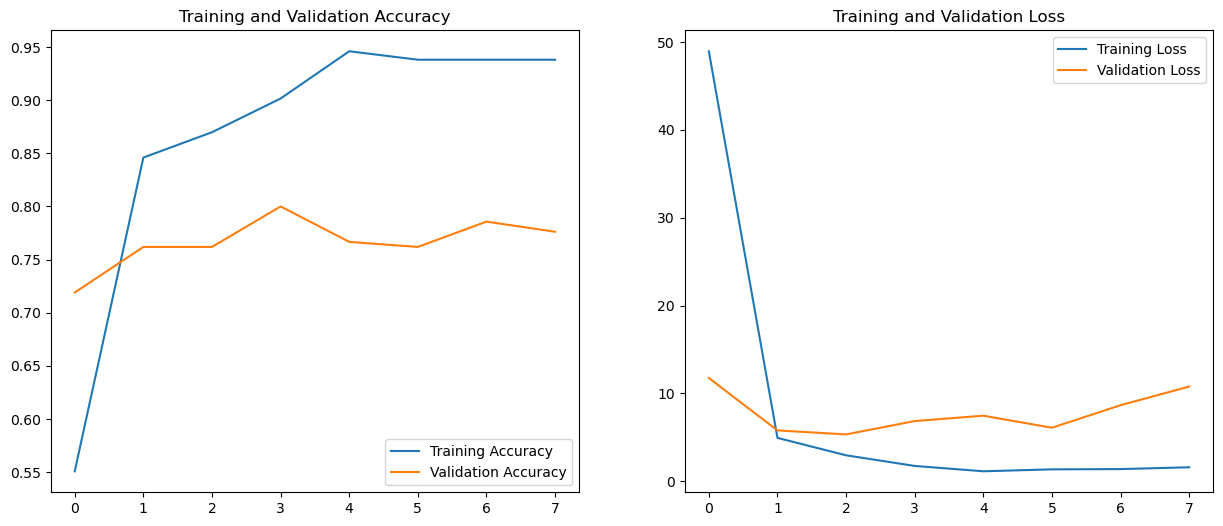

In [55]:
# Affichage de l'historique d'entraînement du modèle à travers les époques
plots(history1)

### Classification avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [72]:
# Définition de la taille de batch pour le modèle
batch_size = 32

# Définition d'une fonction qui charge et prépare les données d'un répertoire donné
# path: le chemin du répertoire contenant les données
# validation_split: fraction du jeu de données à utiliser pour la validation
# data_type: type de données à charger (train, test, validation)
def dataset_fct(path, validation_split=0, data_type=None) :
    # Utilisation de la fonction image_dataset_from_directory pour charger les images du répertoire
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',# La fonction utilise les noms des dossiers pour déterminer les étiquettes
                                                                      # définir le mode de labels des données chargées
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type # fractionner les données pour la validation
                    )
    return dataset

On crée un fonction 2 qui va ajouter des couches de data augmentation à notre modèle, avec des retournements, des rotations et des zooms.

In [73]:
def create_model_fct2():
    
    # Définition des transformations aléatoires des images
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.5),
        RandomZoom(0.5),
    ])
    
    # Importation de l'architecture VGG16 pré-entraînée
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False # On fige les poids des couches
    
    # Définition du modèle
    model = Sequential([
        data_augmentation, # Utilisation des transformations aléatoires
        Rescaling(1./127.5, offset=-1), # Réduction de la plage de valeurs des pixels à [-1, 1]
        model_base, # Ajout de l'architecture VGG16 figée
        Flatten(), # Mise à plat des résultats
        Dense(256, activation='relu'),
        Dropout(0.5), # Désactivation aléatoire de certaines unités du réseau
        Dense(7, activation='softmax') # Couche de sortie avec la fonction d'activation softmax
    ])
    
    # Compilation du modèle avec la fonction de coût "categorical_crossentropy" et l'optimiseur "adam"
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

On créé notre modèle.

In [74]:
# Spécifier le périphérique pour l'exécution du modèle (GPU ou CPU)
with tf.device('/gpu:0'): 

    # Créer le modèle en utilisant la fonction create_model_fct2()
    model2 = create_model_fct2()

# Spécifier le chemin pour enregistrer les meilleurs poids du modèle
model2_save_path = "./model2_best_weights.h5"

# Définir un point de contrôle pour enregistrer les meilleurs poids en fonction de la perte de validation
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Définir un point d'arrêt anticipé pour arrêter l'entraînement si la perte de validation ne s'améliore pas pendant un certain nombre d'époques
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Mettre en place une liste de rappels pour être utilisés lors de l'entraînement du modèle
callbacks_list = [checkpoint, es]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                

In [75]:
# Créer un ensemble de données d'entraînement en utilisant la fonction dataset_fct() avec une division de validation de 25% et un type de données 'training'
dataset_train = dataset_fct(path, validation_split=0.3, data_type='training')

# Créer un ensemble de données de validation en utilisant la fonction dataset_fct() avec une division de validation de 25% et un type de données 'validation'
dataset_val = dataset_fct(path, validation_split=0.3, data_type='validation')

# Créer un ensemble de données de test en utilisant la fonction dataset_fct() sans division de validation (validation_split=0) et aucun type de données spécifié (data_type=None)
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 588 files for training.
Found 840 files belonging to 7 classes.
Using 252 files for validation.
Found 210 files belonging to 7 classes.


On entraine nos dernières couches avec nos images

In [76]:
# Spécifier le périphérique pour l'exécution du modèle (GPU ou CPU)
with tf.device('/gpu:0'): 

    # Entraîner le modèle en utilisant la fonction fit() avec l'ensemble de données d'entraînement, l'ensemble de données de validation, la taille de lot (batch_size) et les rappels définis précédemment (callbacks_list)
    # Enregistrer l'historique d'entraînement dans la variable history2
    # Afficher le progrès de l'entraînement avec verbose=1
    history2 = model2.fit(dataset_train, validation_data=dataset_val, batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


2023-04-03 12:06:42.476408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.8042 - accuracy: 0.2925

2023-04-03 12:06:58.324370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.16268, saving model to ./model2_best_weights.h5
19/19 [==============================] - 23s 1s/step - loss: 2.8042 - accuracy: 0.2925 - val_loss: 1.1627 - val_accuracy: 0.5675
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 1.3099 - accuracy: 0.5272
Epoch 2: val_loss improved from 1.16268 to 0.95726, saving model to ./model2_best_weights.h5
19/19 [==============================] - 21s 1s/step - loss: 1.3099 - accuracy: 0.5272 - val_loss: 0.9573 - val_accuracy: 0.6825
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.5102
Epoch 3: val_loss did not improve from 0.95726
19/19 [==============================] - 21s 1s/step - loss: 1.3054 - accuracy: 0.5102 - val_loss: 0.9847 - val_accuracy: 0.6230
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 1.2113 - accuracy: 0.5561
Epoch 4: val_loss did not improve from 0.95726
19/19 [==============================] - 22s 1s/step -

On évalue le modèle sur les données d'entrainement et de validation

In [77]:
# Évaluer la précision du modèle sur l'ensemble de données d'entraînement en utilisant la fonction evaluate()
# Enregistrer la perte et la précision dans les variables loss et accuracy
loss, accuracy = model2.evaluate(dataset_train, verbose=False)

# Afficher la précision d'entraînement en formatant la valeur de précision
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

# Évaluer la précision du modèle sur l'ensemble de données de validation en utilisant la fonction evaluate()
# Enregistrer la perte et la précision dans les variables loss et accuracy
loss, accuracy = model2.evaluate(dataset_val, verbose=False)

# Afficher la précision de validation en formatant la valeur de précision
print("Validation Accuracy :  {:.4f}".format(accuracy))

Training Accuracy   : 0.8248

Validation Accuracy :  0.7540


On charge les poids du modèle, et on évalue le modèle sur les données de validation et de test

In [78]:
# Charger les poids enregistrés du modèle en utilisant la fonction load_weights() et le chemin spécifié précédemment (model7_save_path)
#model2.load_weights(model2_save_path)

# Évaluer la précision du modèle chargé sur l'ensemble de données de validation en utilisant la fonction evaluate()
# Enregistrer la perte et la précision dans les variables loss et accuracy
loss, accuracy = model2.evaluate(dataset_val, verbose=False)

# Afficher la précision de validation en formatant la valeur de précision
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Évaluer la précision du modèle chargé sur l'ensemble de données de test en utilisant la fonction evaluate()
# Enregistrer la perte et la précision dans les variables loss et accuracy
loss, accuracy = model2.evaluate(dataset_test, verbose=False)

# Afficher la précision de test en formatant la valeur de précision
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7540
Test Accuracy       :  0.7714


On affiche l'historique de accuracy et loss

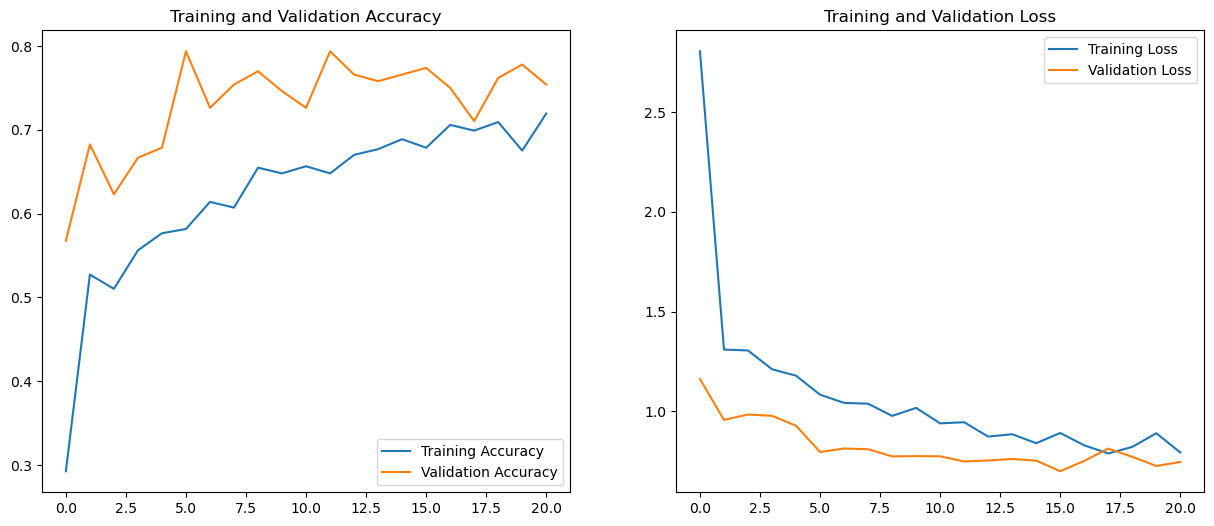

In [79]:
# Afficher l'historique de l'entraînement avec plots() en utilisant la variable d'historique history2
plots(history2)